## Classification with BERT

* Acknowledgements
* Import libraries
* Load & Prepare Data
* Model definition
* Model training 
* Model evaluation

### Acknowledgements

Reference: 
* https://www.tensorflow.org/text/tutorials/classify_text_with_bert
* https://www.tensorflow.org/text/tutorials/bert_glue
* https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
* https://www.tensorflow.org/tutorials/keras/overfit_and_underfit
* https://www.tensorflow.org/guide/keras/train_and_evaluate
* https://www.tensorflow.org/api_docs/python/tf/data/Dataset
* https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3
* https://github.com/Alihassan7726/Fine-tuning-BERT-for-semantic-sentence-pairs-classification/blob/main/Semantic_Text_Classification.ipynb
* https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/
* https://machinelearningmastery.com/k-fold-cross-validation/
* https://machinelearningmastery.com/how-to-configure-k-fold-cross-validation/
* https://www.youtube.com/watch?v=7kLi8u2dJz0
* https://www.youtube.com/watch?v=hOCDJyZ6quA
* https://www.kaggle.com/foolofatook/news-classification-using-bert
* https://www.kaggle.com/abhinand05/bert-for-humans-tutorial-baseline
* https://www.kaggle.com/javaidnabi/toxic-comment-classification-using-bert

###  Import libraries

In [1]:
!pip install -q tf-models-official

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
tensorflow-transform 1.5.0 requires numpy<1.20,>=1.16, but you have numpy 1.20.3 which is incompatible.
tensorflow-transform 1.5.0 requires pyarrow<6,>=1, but you have pyarrow 6.0.1 which is incompatible.
tensorflow-transform 1.5.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,<2.8,>=1.15.2, but you have tensorflow 2.8.0 which is incompatible.
tensorflow-io 0.21.0 requires tensorflow<2.7.0,>=2.6.0, but you have tensorflow 2.8.0 which is incompatible.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, but you have tensorflow-io-gcs-filesystem 0.24.0 which is incompatible.


In [2]:
!pip install imbalanced-learn

In [3]:
!pip install transformers

In [4]:
!pip install tfa-nightly

In [5]:
!pip install tensorflow-text

In [6]:
!pip install --upgrade tensorflow-estimator==2.6.0
!pip install keras==2.6.*

  Using cached keras-2.6.0-py2.py3-none-any.whl (1.3 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
tensorflow 2.8.0 requires keras<2.9,>=2.8.0rc0, but you have keras 2.6.0 which is incompatible.
tensorflow-transform 1.5.0 requires numpy<1.20,>=1.16, but you have numpy 1.20.3 which is incompatible.
tensorflow-transform 1.5.0 requires pyarrow<6,>=1, but you have pyarrow 6.0.1 which is incompatible.
tensorflow-transform 1.5.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,<2.8,>=1.15.2, but you have tensorflow 2.8.0 which is incompatible.
tensorflow-io 0.21.0 requires tensorflow<2.7.0,>=2.6.0, but you have tens

In [7]:
!pip install h5py

In [8]:
from nltk import word_tokenize
from official.nlp import optimization
from seaborn import heatmap
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, balanced_accuracy_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from pandas import DataFrame, concat
from numpy import array, round
from random import shuffle
from collections import Counter
from statistics import mean
from json import load
from functools import reduce
from keras.models import load_model
from sklearn.dummy import DummyClassifier
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.pyplot as plt
import sklearn.datasets

# Filter out all messages 
tf.get_logger().setLevel('ERROR')

2022-04-11 07:47:54.794075: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:
2022-04-11 07:47:54.794142: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Load & Prepare Data

##### BERT is trained on a set of Windows 10 (v 1803) configuration settings $\Gamma_{W10}$. A setting $ \gamma \in \Gamma_{W10} $ was labeled according to the following scheme:
* true (security-relevant):  $ p(\gamma) \Longleftrightarrow \exists r \in \mathcal{S}_{CIS, W10}:  \varpi (r) = \gamma $
* false (not security-relevant):  $\neg p(\gamma) \Longleftrightarrow \nexists r \in \mathcal{S}_{CIS, W10}:  \varpi (r) = \gamma $


Configuration settings concerning Internet Explorer are sorted out as they are treated in a separate guide.

In [9]:
def load_prepare_data(path, name):
    """
    1. Load labeled configuration settings from it-sec dataset
    2. Remove Internet Explorer settings
    3. Prepare dataframe for binary classification
    
    Args:
    path: path to data
    name: name of system variant
    
    Returns: 
    A dataframe of the system variant
    
    """
    with open(path) as f_read:
        docs_all = load(f_read)
    shuffle(docs_all)
    df = DataFrame([doc for doc in docs_all if doc["text"].lower().find("windows components. internet explorer.")==-1])
    df['sec']=df['is_security_relevant'].apply(lambda x: 1 if x==True else 0)
    df = df.drop('is_security_relevant', 1)
    count = Counter(df['sec'])
    print(f"{name} non security settings: {count[0]}")
    print(f"{name} security settings: {count[1]}\n")
    return df

In [10]:
docs: dict = {"CIS_18": load_prepare_data("../input/it-sec/docs/cis/1803/all_docs.json","CIS 1803"), 
              "CIS_19": load_prepare_data("../input/it-sec/docs/cis/1909/all_docs.json", "CIS 1909"), 
              "CIS_Server": load_prepare_data("../input/it-sec/docs/cis/server2016/all_docs.json", "CIS Server2016" ), 
              "SIE_19": load_prepare_data("../input/it-sec/docs/siemens/1909/all_docs.json", "Siemens 1909"), 
              "SIE_Server": load_prepare_data("../input/it-sec/docs/siemens/server2016/all_docs.json","Siemens Server2016")}

CIS 1803 non security settings: 2338
CIS 1803 security settings: 238

CIS 1909 non security settings: 2442
CIS 1909 security settings: 246

CIS Server2016 non security settings: 2274
CIS Server2016 security settings: 156

Siemens 1909 non security settings: 2500
Siemens 1909 security settings: 188

Siemens Server2016 non security settings: 2238
Siemens Server2016 security settings: 192



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


#### Analyze input data

Bert limits each input to 512 tokens (including CLS and SEP). Therefore the average input length and the amount of truncated settings is investigated. 

In [11]:
ls_len = [len(word_tokenize(rule)) for rule in docs["CIS_18"]['text']]
maxLen=reduce(lambda x,y: x if x>y else y, ls_len)
totLen= reduce(lambda x,y: x+y, ls_len)
truncated = [label for rule,label in zip(docs["CIS_18"]['text'], docs["CIS_18"]['sec']) if len(word_tokenize(rule))>510]
print(f"Maximum number of input tokens: {maxLen}")
print(f"Average number of input tokens: {totLen/len(docs['CIS_18']):.0f}")
print(f"Truncated input settings: {len(truncated)}")
print(f"Truncated security settings: {Counter(truncated)[1]}")

Maximum number of input tokens: 1147
Average number of input tokens: 157
Truncated input settings: 15
Truncated security settings: 2


#### Drop duplicates occurring in Computer and User settings

Windows configuration settings are categorized as Computer or User settings. 

Some settings occur in both sections. These settings can be either labeled equally or differently due to hierarchical dependencies. 

In the following, duplicates are removed: in case of differing labels the security label is kept.

In [12]:
docs["CIS_18"].groupby('sec').describe()

text                                                               
    count unique                                                top freq
sec                                                                     
0    2338   2039  Windows Components. Windows Error Reporting. S...    2
1     238    237  Windows Components. Windows Installer. Always ...    2

In [13]:
def drop_duplicates(settings, name):
    """
    1. Drop equally labeled duplicates 
    2. Drop differently labeled duplicates
    3. Shuffle 
    
    Args: 
    settings: dataframe
    name: name of system variant
    
    Returns: 
    A dataframe of the system variant
    
    """
    settings = settings.drop_duplicates().sort_values("sec")
    settings = settings.drop_duplicates(subset="text", keep='last')
    settings = settings.sample(frac=1)
    print(f"{name} total size: {str(len(settings))}")
    return settings

In [14]:
for e in docs:
    docs[e]=drop_duplicates(docs[e],e)

CIS_18 total size: 2238
CIS_19 total size: 2325
CIS_Server total size: 2092
SIE_19 total size: 2325
SIE_Server total size: 2092


### Model definition

* L=2 hidden layers (i.e., Transformer blocks)
* Hidden size of H=128
* A=2 attention heads

In [15]:
tfhub_handle_encoder ='https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


#### Standard Preprocessing model

By default the bert preprocessing model truncates the input to 128 tokens. As the example sentence contains only 7 tokens (+ CLS, SEP), the input mask is padded with zeros. 

In [16]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

text_test = ['This is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

2022-04-11 07:48:04.548283: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:
2022-04-11 07:48:04.548347: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-11 07:48:04.548375: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (8b2ad99d3f17): /proc/driver/nvidia/version does not exist
2022-04-11 07:48:04.548687: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the

Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [[1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In the following, the preprocess model is customized to support a sequence length of 512 tokens. 

In [17]:
def make_bert_preprocess_model(sentence_features, seq_length=512):
    """Returns Model mapping string features to BERT inputs.

    Args:
    sentence_features: a list with the names of string-valued features.
    seq_length: an integer that defines the sequence length of BERT inputs.

    Returns:
    A Keras Model that can be called on a list or dict of string Tensors
    (with the order or names, resp., given by sentence_features) and
    returns a dict of tensors for input to BERT.
    """

    input_segments = [
      tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
      for ft in sentence_features]

    # Tokenize the text to word pieces.
    bert_preprocess = hub.load(tfhub_handle_preprocess)
    tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
    segments = [tokenizer(seg) for seg in input_segments]

    # Optional: Trim segments in a smart way to fit seq_length.
    truncated_segments = segments

    # Pack inputs
    packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs,
                          arguments=dict(seq_length=seq_length),
                          name='packer')
    model_inputs = packer(truncated_segments)
    return tf.keras.Model(input_segments, model_inputs)

In [18]:
test_preprocess_model = make_bert_preprocess_model(['my_input1'])
test_text = [array(['Some random test sentence. Second test sentence!'])]
text_preprocessed = test_preprocess_model(test_text)
print('Input Mask     : ', text_preprocessed['input_mask'])
print('Keys           : ', list(text_preprocessed.keys()))
print('Shape Word Ids : ', text_preprocessed['input_word_ids'].shape)
print('Word Ids       : ', text_preprocessed['input_word_ids'][0, :16])
print('Shape Mask     : ', text_preprocessed['input_mask'].shape)
print('Input Mask     : ', text_preprocessed['input_mask'][0, :16])
print('Shape Type Ids : ', text_preprocessed['input_type_ids'].shape)
print('Type Ids       : ', text_preprocessed['input_type_ids'][0, :16])

Input Mask     :  tf.Tensor(
[[1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0

#### Functional model

In [19]:
def build_classifier_model(max_seq_length = 512):
    """
    Args: 
    max_seq_length: max. # of input tokens
    
    Returns: 
    A classifier model
    """
    input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                         name = "input_word_ids")
    input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name = "input_mask")
    input_type_ids=tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name = "input_type_ids")
    encoder_inputs = dict(input_word_ids = input_word_ids ,input_mask = input_mask,input_type_ids = input_type_ids)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    # dropout layer to tackle the overfitting -> drop 20%
    net = tf.keras.layers.Dropout(0.2, name="dropout")(net)
    net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
    model = tf.keras.Model(
      inputs={
      'input_word_ids': input_word_ids,
       'input_mask': input_mask,
       'input_type_ids': input_type_ids
    },
      outputs=net)
    return model

#### Metrics

In [20]:
bin_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
metrics = [tf.keras.metrics.BinaryAccuracy(), 
          tf.keras.metrics.Recall(), 
          tf.keras.metrics.Precision()]

### Model training

5-fold split with combined over- and undersampling

In [21]:
def create_tf_dataset(data_set): 
    """
    Transform dataframe to tensorflow dataset
    
    Args: 
    data_set: pandas dataframe
    
    Returns: 
    A tensorflow dataset
    """
    data_set = tf.data.Dataset.from_tensor_slices(dict(data_set))
    return load_dataset_from_tfds(data_set, bert_preprocess_model, batch_size)

def load_dataset_from_tfds(dataset, prep_model, batch_s):
    """
    Apply preprocessing model to dataset.
    Map settings to label.
    """
    # dataset = dataset.repeat()
    dataset = dataset.batch(batch_s)
    dataset = dataset.map(lambda ex: (prep_model(ex),ex['sec']), num_parallel_calls = tf.data.experimental.AUTOTUNE)
    dataset = dataset.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

def over_under_sampling(train_d):
    """
    1. Apply oversampling on minority class with desired ratio of 0.4 after resampling 
    2. Apply undersampling on majority class with desired ratio of 0.5 after resampling
       (ratio = # minority samples / # majority samples)
    3. Shuffle
    """
    over = RandomOverSampler(sampling_strategy=0.4)
    under = RandomUnderSampler(sampling_strategy=0.5)
    y_train = train_d.iloc[:,1:]
    x_train = train_d.iloc[:,:-1]
    x_train_fit, y_train_fit = over.fit_resample(x_train, y_train)
    x_train_fit, y_train_fit = under.fit_resample(x_train_fit, y_train_fit)
    train_fit = concat([x_train_fit,y_train_fit], axis=1)
    return train_fit.sample(frac=1)

def filter_test_set(target_d, train_d, test_len):
    """
    Test set creation for other system variants:
    Settings used for classifier training are filtered out as they occur in other datasets as well. 
    Size of test sets is trimmed to same length.
    
    Args:
    target_d: data of system variant
    train_d: training data
    test_len: length of test sets
    
    Returns: 
    The test set of a system variant
    """
    return target_d[~target_d.text.isin(train_d.text)].sample(n=test_len, replace=False)

def evaluate(y_true, y_pred, rec, prec, name, metrics_d):
    """
    Evaluate and print all metrics for system variant name 
    """
    bal_acc = balanced_accuracy_score(y_true,y_pred)
    f1 = f1_score(y_true,y_pred, zero_division=0)
    sec_out=Counter(y_pred)[1]
    metr = [rec, prec, f1, bal_acc, sec_out]
    for m,v in zip(metrics_d[name],metr):
        metrics_d[name][m].append(v)
    return metrics_d
    
def evaluate_baseline_model(test_d, train_d, metrics_d, name):
    """
    Evaluates a uniform random classifier as baseline model
    """
    test_y = test_d.iloc[:,1].to_numpy()
    test_x = test_d.iloc[:,0].to_numpy()
    train_y = train_d.iloc[:,1].to_numpy()
    train_x = train_d.iloc[:,0].to_numpy()
    rc_name = f"RC_{name}"
    clf = DummyClassifier(strategy='uniform', random_state=0)
    clf = clf.fit(train_x, train_y)
    y_pred = clf.predict(test_x)
    prec = precision_score(test_y, y_pred, zero_division=0)
    rec = recall_score(test_y, y_pred, zero_division=0)
    metrics_d = evaluate(test_y, y_pred,rec,prec, rc_name, metrics_d)
    return metrics_d

def evaluate_model(test_d, train_set, train_d, len_test_set, name, metrics_d, transform=True):
    """
    Evaluates the classifier on test set of system variant name
    """
    if transform:
        test_d = filter_test_set(test_d,train_set, len_test_set)
    test_tf = create_tf_dataset(test_d)
    loss, binary_accuracy, rec, prec = classifier_model.evaluate(test_tf, verbose=0)
    y_pred = list(map(int,round(classifier_model.predict(test_tf)))) 
    y_true = test_d.sec
    metrics_d = evaluate(y_true, y_pred, rec, prec, name, metrics_d)
    metrics_d = evaluate_baseline_model(test_d,train_d,metrics_d, name)
    return metrics_d
    
def sub_plot(index, epoc, metr, metr_val, label, title, loc):
    """
    Sub plot creation
    """
    plt.subplot(4, 1, index)
    plt.plot(epoc, metr, 'r', label=f'Training {label}')
    plt.plot(epoc, metr_val, 'b', label=f'Validation {label}')
    plt.title(title)
    plt.ylabel(label)
    plt.xlabel('Epochs')
    plt.legend(loc=loc)

def plot_history(hist):
    """
    Plot training and validation history of metrics
    """
    history_dict = hist.history
    epoc = range(1, len(history_dict['loss']) + 1)
    fig = plt.figure(figsize=(10, 20))
    fig.tight_layout()
    sub_plot(1,epoc, history_dict['loss'], history_dict['val_loss'], "Loss", "Training and validation loss", "lower left")
    sub_plot(2,epoc, history_dict['recall'], history_dict['val_recall'], "Recall", "Training and validation recall", "lower right")
    plt.show()

def plot_cm(labels, predictions, name="", p=0.5):
    """
    Plot heatmap of confusion matrix
    """
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.savefig(f'{name}_heatmap.png')
    plt.show()

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1

Test_data: Counter({0: 407, 1: 41})
Val_data: Counter({0: 308, 1: 50})
Train_data before Sampling: Counter({0: 1286, 1: 146})
Train_data after Sampling: Counter({0: 1028, 1: 514})


/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['sec'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


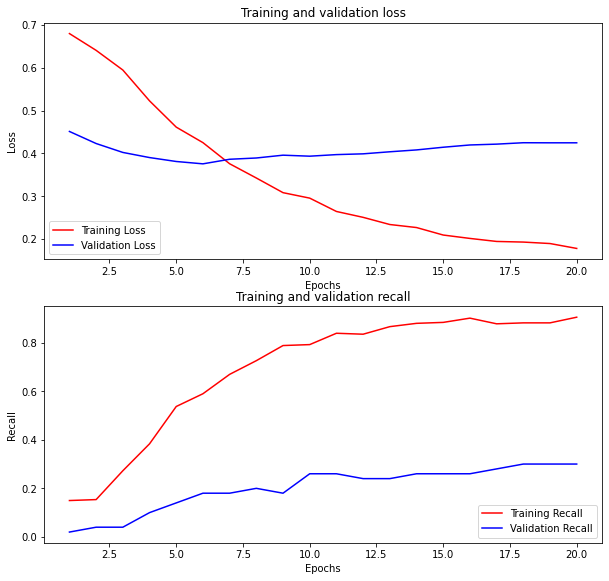

/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['sec'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['sec'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['sec'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['sec'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Test_data: Counter({0: 401, 1: 47})
Val_data: Counter({0: 315, 1: 43})
Train_data before Sampling: Counter({0: 1285, 1: 147})
Train_data after Sampling: Counter({0: 1028, 1: 514})


/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['sec'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


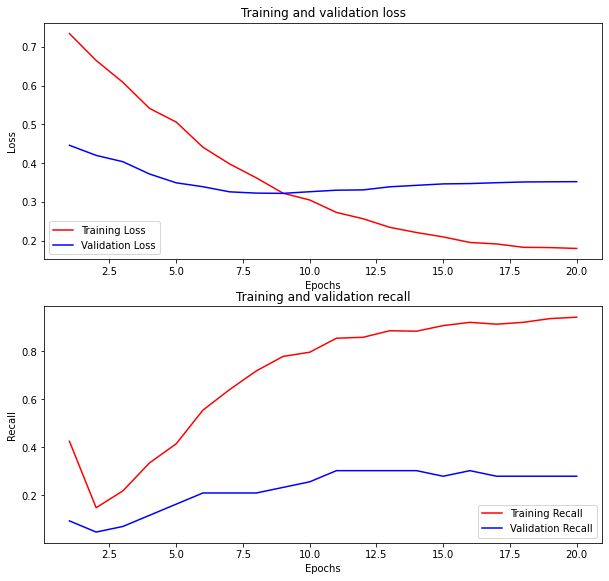

/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['sec'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['sec'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['sec'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['sec'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Test_data: Counter({0: 394, 1: 54})
Val_data: Counter({0: 324, 1: 34})
Train_data before Sampling: Counter({0: 1283, 1: 149})
Train_data after Sampling: Counter({0: 1026, 1: 513})


/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['sec'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


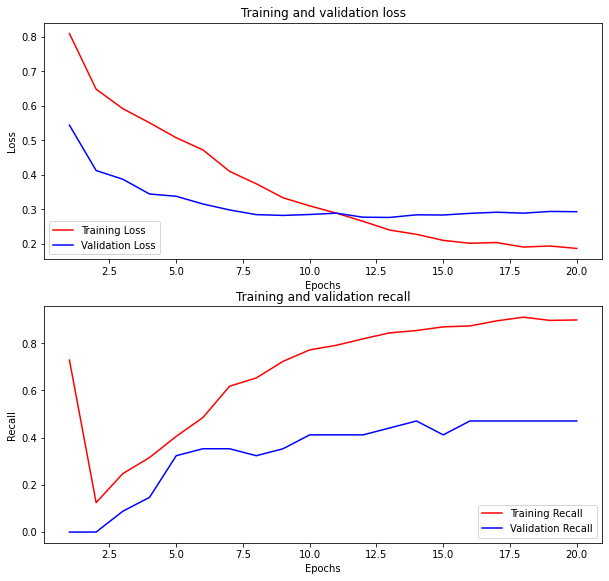

/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['sec'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['sec'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['sec'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['sec'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Test_data: Counter({0: 399, 1: 48})
Val_data: Counter({0: 312, 1: 47})
Train_data before Sampling: Counter({0: 1290, 1: 142})
Train_data after Sampling: Counter({0: 1032, 1: 516})


/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['sec'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


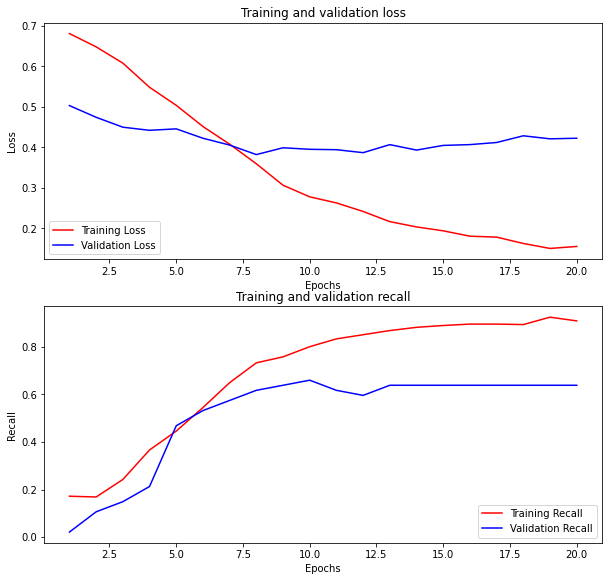

/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['sec'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['sec'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['sec'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['sec'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Test_data: Counter({0: 400, 1: 47})
Val_data: Counter({0: 312, 1: 47})
Train_data before Sampling: Counter({0: 1289, 1: 143})
Train_data after Sampling: Counter({0: 1030, 1: 515})


/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['sec'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


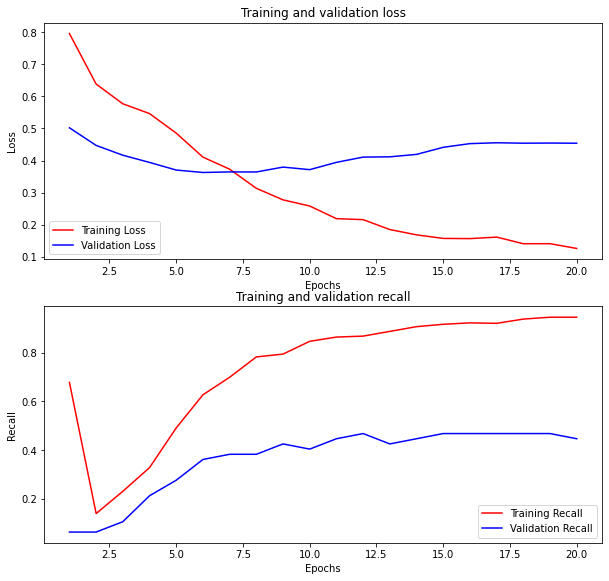

/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['sec'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['sec'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['sec'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['sec'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


In [22]:
print(f'Training model with {tfhub_handle_encoder}\n')

# Shuffle
df_all = docs["CIS_18"].sample(frac=1)

metrics_dict: dict = {"RC_CIS_18": [],
                      "RC_CIS_19": [],
                      "RC_CIS_Server": [],
                      "RC_SIE_19": [],
                      "RC_SIE_Server": [],
                      "CIS_18" : [], 
                      "CIS_19" : [], 
                      "CIS_Server" : [], 
                      "SIE_19" : [], 
                      "SIE_Server" : []}
for e in metrics_dict:
    metrics_dict[e]={"Recall" : [], 
                     "Precision" : [], 
                     "F1-Score" : [], 
                     "BalAcc" : [], 
                     "Sec_Out": []}
features = ['text']
bert_preprocess_model = make_bert_preprocess_model(features)
epochs = 20
batch_size = 32
validation_batch_size=8

# K-fold cross validation
kf = KFold(n_splits=5)
for trainIndex, testIndex in kf.split(df_all):
    # Create train, validation and test set
    data_train, test_df = df_all.iloc[trainIndex], df_all.iloc[testIndex]
    test_len = len(test_df)
    print(f"Test_data: {Counter(test_df.sec)}")
    train_df, val_df = train_test_split(data_train, test_size=0.2)
    print(f"Val_data: {Counter(val_df.sec)}")
    print(f"Train_data before Sampling: {Counter(train_df.sec)}")
    train_df_fit = over_under_sampling(train_df)
    print(f"Train_data after Sampling: {Counter(train_df_fit.sec)}")
    train_tf_data = create_tf_dataset(train_df_fit)
    val_tf_data = create_tf_dataset(val_df)
    test_tf_data = create_tf_dataset(test_df)

    # Build, compile and train classifier
    classifier_model = build_classifier_model()
    steps_per_epoch = len(train_df_fit)//batch_size
    num_train_steps = steps_per_epoch * epochs
    num_warmup_steps = int(0.1*num_train_steps)
    init_lr = 3e-5
    optimizer = optimization.create_optimizer(init_lr=init_lr,
                                              num_train_steps=num_train_steps,
                                              num_warmup_steps=num_warmup_steps,
                                              optimizer_type='adamw')
    classifier_model.compile(optimizer=optimizer, loss=bin_loss, metrics=metrics) 
    history = classifier_model.fit(x=train_tf_data, epochs=epochs, batch_size=batch_size, validation_data=val_tf_data, validation_batch_size= validation_batch_size, verbose=0)    
    
    # Evaluate training and validation history
    plot_history(history)
    metrics_dict = evaluate_model(test_df, data_train, train_df_fit, test_len, "CIS_18", metrics_dict, transform=False)
    metrics_dict = evaluate_model(docs["CIS_19"], data_train, train_df_fit, test_len, "CIS_19", metrics_dict)
    metrics_dict = evaluate_model(docs["CIS_Server"], data_train, train_df_fit, test_len, "CIS_Server", metrics_dict)
    metrics_dict = evaluate_model(docs["SIE_19"], data_train, train_df_fit, test_len, "SIE_19", metrics_dict)
    metrics_dict = evaluate_model(docs["SIE_Server"], data_train, train_df_fit, test_len, "SIE_Server", metrics_dict)

### Model evaluation

In [23]:
for e in metrics_dict:
    print(f"{e}:\n")
    for s in metrics_dict[e]:
        print(f"{s}: {int(round((mean(metrics_dict[e][s])*100))) if s!='Sec_Out' else mean(metrics_dict[e][s])} {'%' if s!='Sec_Out' else ''}")
    print("\n")

RC_CIS_18:

Recall: 57 %
Precision: 11 %
F1-Score: 19 %
BalAcc: 52 %
Sec_Out: 238 


RC_CIS_19:

Recall: 54 %
Precision: 13 %
F1-Score: 21 %
BalAcc: 51 %
Sec_Out: 238 


RC_CIS_Server:

Recall: 50 %
Precision: 6 %
F1-Score: 11 %
BalAcc: 48 %
Sec_Out: 238 


RC_SIE_19:

Recall: 49 %
Precision: 11 %
F1-Score: 17 %
BalAcc: 48 %
Sec_Out: 238 


RC_SIE_Server:

Recall: 50 %
Precision: 10 %
F1-Score: 17 %
BalAcc: 48 %
Sec_Out: 238 


CIS_18:

Recall: 43 %
Precision: 43 %
F1-Score: 42 %
BalAcc: 68 %
Sec_Out: 48 


CIS_19:

Recall: 55 %
Precision: 45 %
F1-Score: 49 %
BalAcc: 72 %
Sec_Out: 70.2 


CIS_Server:

Recall: 50 %
Precision: 29 %
F1-Score: 36 %
BalAcc: 70 %
Sec_Out: 51 


SIE_19:

Recall: 46 %
Precision: 35 %
F1-Score: 39 %
BalAcc: 67 %
Sec_Out: 69.8 


SIE_Server:

Recall: 50 %
Precision: 48 %
F1-Score: 48 %
BalAcc: 72 %
Sec_Out: 51.6 




#### Save model

In [24]:
dataset_name = 'small'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))
classifier_model.save(saved_model_path, include_optimizer=False)

2022-04-11 11:14:12.406384: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


#### Examples

In [25]:
def load_dataset_from_tfds2(dataset, prep_model):
    """
    Apply preprocessing model to dataset
    """
    # dataset = dataset.repeat()
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(lambda ex: (prep_model(ex)), num_parallel_calls = tf.data.experimental.AUTOTUNE)
    dataset = dataset.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [26]:
def print_my_examples(inputs, results):
    """
    Evaluation of single security-relevant settings
    """
    result_for_printing = [f'input: {i} : score: {results[i][0]:.6f}' for i in range(len(inputs))]
    print(*result_for_printing, sep='\n')
    print()

examples_1803 = [
    # Sec
    "MSS (Legacy). MSS: (DisableIPSourceRouting IPv6) IP source routing protection level (protects against packet spoofing). MSS: (DisableIPSourceRouting IPv6) IP source routing protection level (protects against packet spoofing)",
    # Sec
    "LAPS. Do not allow password expiration time longer than required by policy. When you enable this setting, planned password expiration longer than password age dictated by Password Settings policy is NOT allowed. When such expiration is detected, password is changed immediately and password expiration is set according to policy. When you disable or not configure this setting, password expiration time may be longer than required by Password Settings policy.",
    # Sec
    "Control Panel. Personalization. Prevent enabling lock screen slide show. Disables the lock screen slide show settings in PC Settings and prevents a slide show from playing on the lock screen. By default, users can enable a slide show that will run after they lock the machine. If you enable this setting, users will no longer be able to modify slide show settings in PC Settings, and no slide show will ever start.",
    # Sec
    "Start Menu and Taskbar. Notifications. Turn off notifications network usage. This policy setting blocks applications from using the network to send notifications to update tiles, tile badges, toast, or raw notifications. This policy setting turns off the connection between Windows and the Windows Push Notification Service (WNS). This policy setting also stops applications from being able to poll application services to update tiles.           If you enable this policy setting, applications and system features will not be able receive notifications from the network from WNS or via notification polling APIs.           If you enable this policy setting, notifications can still be raised by applications running on the machine via local API calls from within the application.           If you disable or do not configure this policy setting, the client computer will connect to WNS at user login and applications will be allowed to poll for tile notification updates in the background.           No reboots or service restarts are required for this policy setting to take effect.",
    # Sec
    "System. Internet Communication Management. Internet Communication settings. Turn off Search Companion content file updates. This policy setting specifies whether Search Companion should automatically download content updates during local and Internet searches. When users search the local computer or the Internet, Search Companion occasionally connects to Microsoft to download an updated privacy policy and additional content files used to format and display results. If you enable this policy setting, Search Companion does not download content updates during searches. If you disable or do not configure this policy setting, Search Companion downloads content updates unless the user is using Classic Search. Note: Internet searches still send the search text and information about the search to Microsoft and the chosen search provider. Choosing Classic Search turns off the Search Companion feature completely.",
    # Sec
    "System. Locale Services. Disallow copying of user input methods to the system account for sign-in. This policy prevents automatic copying of user input methods to the system account for use on the sign-in screen. The user is restricted to the set of input methods that are enabled in the system account.         Note this does not affect the availability of user input methods on the lock screen or with the UAC prompt.         If the policy is Enabled, then the user will get input methods enabled for the system account on the sign-in page.         If the policy is Disabled or Not Configured, then the user will be able to use input methods enabled for their user account on the sign-in page.",
    # Sec
    "System. Group Policy. Continue experiences on this device. This policy setting determines whether the Windows device is allowed to participate in cross-device experiences (continue experiences). If you enable this policy setting, the Windows device is discoverable by other Windows devices that belong to the same user, and can participate in cross-device experiences. If you disable this policy setting, the Windows device is not discoverable by other devices, and cannot participate in cross-device experiences. If you do not configure this policy setting, the default behavior depends on the Windows edition. Changes to this policy take effect on reboot.",
    # Sec
    "Windows Components. Credential User Interface. Prevent the use of security questions for local accounts. If you turn this policy setting on, local users won\u2019t be able to set up and use security questions to reset their passwords.",
    # Sec
    "Windows Components. Remote Desktop Services. Remote Desktop Session Host. Device and Resource Redirection. Do not allow LPT port redirection. This policy setting specifies whether to prevent the redirection of data to client LPT ports during a Remote Desktop Services session. You can use this setting to prevent users from mapping local LPT ports and redirecting data from the remote computer to local LPT port peripherals. By default, Remote Desktop Services allows LPT port redirection. If you enable this policy setting, users in a Remote Desktop Services session cannot redirect server data to the local LPT port. If you disable this policy setting, LPT port redirection is always allowed. If you do not configure this policy setting, LPT port redirection is not specified at the Group Policy level.",
    # Sec
    "MSS (Legacy). MSS: (DisableIPSourceRouting) IP source routing protection level (protects against packet spoofing). MSS: (DisableIPSourceRouting) IP source routing protection level (protects against packet spoofing)",
    # Sec
    "Control Panel. Regional and Language Options. Allow input personalization. This policy enables the automatic learning component of input personalization that includes speech, inking, and typing.         Automatic learning enables the collection of speech and handwriting patterns, typing history, contacts, and recent calendar information.  It is required for the use of Cortana.  Some of this collected information may be stored on the user's OneDrive, in the case of inking and typing; some of the information will be uploaded to Microsoft to personalize speech.         Automatic learning for speech may not be available for all languages, even when inking and typing is available.         If this policy is enabled, automatic learning of speech, inking, and typing will be enabled and users cannot change its value via PC Settings.         If this policy is disabled, automatic learning of speech, inking, and typing stops and users cannot change its value via PC Settings.         If this policy is not configured, the user may configure the speech, inking, and typing personalisation setting via PC Settings. "
    ]
    
examples_1909 = [
    # Sec
    "System. Kernel DMA Protection. Enumeration policy for external devices incompatible with Kernel DMA Protection. Enumeration policy for external DMA-capable devices incompatible with DMA remapping. This policy only takes effect when Kernel DMA Protection is enabled and supported by the system. Note: this policy does not apply to 1394, PCMCIA or ExpressCard devices.",
    #Sec
    "Windows Components. Microsoft Edge. Prevent certificate error overrides. Web security certificates are used to ensure a site your users go to is legitimate, and in some circumstances encrypts the data. With this policy, you can specify whether to prevent users from bypassing the security warning to sites that have SSL errors. If enabled, overriding certificate errors are not allowed. If disabled or not configured, overriding certificate errors are allowed.",
    #Sec
    "System. OS Policies. Allow Clipboard synchronization across devices. This policy setting determines whether Clipboard contents can be synchronized across devices.\n            If you enable this policy setting, Clipboard contents are allowed to be synchronized across devices logged in under the same Microsoft account or Azure AD account.\n            If you disable this policy setting, Clipboard contents cannot be shared to other devices.\n            Policy change takes effect immediately.",
    #Sec
    "Windows Components. App Privacy. Let Windows apps activate with voice while the system is locked. This policy setting specifies whether Windows apps can be activated by voice while the system is locked. If you choose the \"User is in control\" option, employees in your organization can decide whether users can interact with applications using speech while the system is locked by using Settings > Privacy on the device. If you choose the \"Force Allow\" option, users can interact with applications using speech while the system is locked and employees in your organization cannot change it. If you choose the \"Force Deny\" option, users cannot interact with applications using speech while the system is locked and employees in your organization cannot change it. If you disable or do not configure this policy setting, employees in your organization can decide whether users can interact with applications using speech while the system is locked by using Settings > Privacy on the device. This policy is applied to Windows apps and Cortana. It takes precedence of the \u201cAllow Cortana above lock\u201d policy. This policy is applicable only when \u201cAllow voice activation\u201d policy is configured to allow applications to be activated with voice.",
    #Sec
    "Windows Components. Microsoft Edge. Allow Sideloading of extension. Sideloading installs and runs unverified extensions in Microsoft Edge. With this policy, you can specify whether unverified extensions can be sideloaded in Microsoft Edge. If enabled or not configured, sideloading of unverified extensions in Microsoft Edge is allowed. If disabled, sideloading of unverified extensions in Microsoft Edge is not allowed. Extensions can be installed only through Microsoft store (including a store for business), enterprise storefront (such as Company Portal) or PowerShell (using Add-AppxPackage).  When disabled, this policy does not prevent sideloading of extensions using Add-AppxPackage via PowerShell. To prevent this, in Group Policy Editor, enable Allows development of Windows Store apps and installing them from an integrated development environment (IDE), which is located at: Computer Configuration > Administrative Templates > Windows Components > App Package Deployment Supported versions: Microsoft Edge on Windows 10, version 1809\nDefault setting: Disabled or not configured\nRelated policies:\n- Allows development of Windows Store apps and installing them from an integrated development environment (IDE)\n- Allow all trusted apps to install\u200b",
    #Sec
    "Windows Components. Windows Defender Antivirus. Configure detection for potentially unwanted applications. Enable or disable detection for potentially unwanted applications. You can choose to block, audit, or allow when potentially unwanted software is being downloaded or attempts to install itself on your computer.         Enabled:\n        Specify the mode in the Options section:\n        -Block: Potentially unwanted software will be blocked.\n        -Audit Mode: Potentially unwanted software will not be blocked, however if this feature would have blocked access if it were set to Block, then a record of the event will be in the event logs.         Disabled:\n        Potentially unwanted software will not be blocked.         Not configured:\n        Same as Disabled.",
    #Sec
    "Windows Components. Windows Defender Application Guard. Configure Windows Defender Application Guard clipboard settings. This policy setting allows you to decide how the clipboard behaves while in Windows Defender Application Guard (Application Guard). If you enable this setting, you must choose from the following behaviors: - Disable clipboard functionality completely between the host and Application Guard - Enable the clipboard to copy content from Application Guard to the host - Enable the clipboard to copy content from the host to Application Guard. Note:\nWe recommend that you don't enable copying from the host to Application Guard. If you enable this functionality, a potentially compromised Application Guard session will have access to the host device\u2019s clipboard and its content. If you choose to enable copying, you must also choose the type of content that can be copied, by using the content options: - 1. Allows text copying. - 2. Allows image copying. - 3. Allows both text and image copying. If you disable or don't configure this setting, all clipboard functionality is turned off in Application Guard.",
    #Sec
    "Windows Components. Windows Defender Application Guard. Turn on Windows Defender Application Guard in Managed Mode. This policy setting enables application isolation through Windows Defender Application Guard (Application Guard). Application Guard uses Windows Hypervisor to create a virtualized environment for apps that are configured to use virtualization-based security isolation. While in isolation, improper user interactions and app vulnerabilities can\u2019t compromise the kernel or any other apps running outside of the virtualized environment. If you enable this setting, Application Guard is turned on for your organization.",
    #Sec
    "Windows Components. Windows Security. App and browser protection. Prevent users from modifying settings. Prevent users from making changes to the Exploit protection settings area in Windows Security.         Enabled:\n        Local users can not make changes in the Exploit protection settings area.         Disabled:\n        Local users are allowed to make changes in the Exploit protection settings area.         Not configured:\n        Same as Disabled.",
    #Sec
    "Windows Components. Windows Update. Configure Automatic Updates. Specifies whether this computer will receive security updates and other important downloads through the Windows automatic updating service. Note: This policy does not apply to Windows RT. This setting lets you specify whether automatic updates are enabled on this computer. If the service is enabled, you must select one of the four options in the Group Policy Setting:         2 = Notify before downloading and installing any updates.         When Windows finds updates that apply to this computer, users will be notified that updates are ready to be downloaded. After going to Windows Update, users can download and install any available updates.         3 = (Default setting) Download the updates automatically and notify when they are ready to be installed         Windows finds updates that apply to the computer and downloads them in the background (the user is not notified or interrupted during this process). When the downloads are complete, users will be notified that they are ready to install. After going to Windows Update, users can install them.         4 = Automatically download updates and install them on the schedule specified below.         When \"Automatic\" is selected as the scheduled install time, Windows will automatically check, download, and install updates. The device will reboot as per Windows default settings unless configured by group policy. (Applies to Windows 10, version 1809 and higher)         Specify the schedule using the options in the Group Policy Setting. For version 1709 and above, there is an additional choice of limiting updating to a weekly, bi-weekly, or monthly occurrence. If no schedule is specified, the default schedule for all installations will be every day at 3:00 AM. If any updates require a restart to complete the installation, Windows will restart the computer automatically. (If a user is signed in to the computer when Windows is ready to restart, the user will be notified and given the option to delay the restart.)         On Windows 8 and later, you can set updates to install during automatic maintenance instead of a specific schedule. Automatic maintenance will install updates when the computer is not in use and avoid doing so when the computer is running on battery power. If automatic maintenance is unable to install updates for 2 days, Windows Update will install updates right away. Users will then be notified about an upcoming restart, and that restart will only take place if there is no potential for accidental data loss.         5 = Allow local administrators to select the configuration mode that Automatic Updates should notify and install updates. (This option has not been carried over to any Win 10 Versions)         With this option, local administrators will be allowed to use the Windows Update control panel to select a configuration option of their choice. Local administrators will not be allowed to disable the configuration for Automatic Updates. If the status for this policy is set to Disabled, any updates that are available on Windows Update must be downloaded and installed manually. To do this, search for Windows Update using Start. If the status is set to Not Configured, use of Automatic Updates is not specified at the Group Policy level. However, an administrator can still configure Automatic Updates through Control Panel.",
    #Sec
    "Windows Components. Windows Update. Remove access to \"Pause updates\" feature. This setting allows to remove access to \"Pause updates\" feature. Once enabled user access to pause updates is removed.",
    #Sec
    "Windows Components. Windows Update. Windows Update for Business. Manage preview builds. Selecting \"Disable preview builds\" will prevent preview builds from installing on the device. This will prevent users from opting into the Windows Insider Program, through Settings -> Update and Security. Selecting \"Disable preview builds once next release is public\" will prevent preview builds from installing once the next Windows release is public. This option is useful when your device is set up to install preview and you want to gracefully opt out the device for flighting. This option will provide preview builds until devices reaches the next public release. Selecting \"Enable preview builds\" will enable preview builds installation on the device. Users can download and install Windows preview builds on their devices by opting-in through Settings -> Update and Security -> Windows Insider Program. Admins can also use other policies to manage flight settings on behalf of users when this value is set."
    ]

examples_data = tf.data.Dataset.from_tensor_slices(examples_1803)
examples_data = load_dataset_from_tfds2(examples_data,bert_preprocess_model)
for elem in examples_data:
    original_results = classifier_model(elem)
    print('Results from dataset CIS 1803:')
    print_my_examples(examples_1803, original_results)

examples2_data = tf.data.Dataset.from_tensor_slices(examples_1909)
examples2_data = load_dataset_from_tfds2(examples2_data,bert_preprocess_model)
for elem in examples2_data:    
    original_results =  classifier_model(elem)
    print('Results from dataset CIS 1909:')
    print_my_examples(examples_1909, original_results)


Results from dataset CIS 1803:
input: 0 : score: 0.985187
input: 1 : score: 0.932844
input: 2 : score: 0.029950
input: 3 : score: 0.873193
input: 4 : score: 0.983863
input: 5 : score: 0.010023
input: 6 : score: 0.981644
input: 7 : score: 0.952192
input: 8 : score: 0.780864
input: 9 : score: 0.989152
input: 10 : score: 0.968782

Results from dataset CIS 1909:
input: 0 : score: 0.005810
input: 1 : score: 0.041820
input: 2 : score: 0.106808
input: 3 : score: 0.497437
input: 4 : score: 0.930697
input: 5 : score: 0.487417
input: 6 : score: 0.968531
input: 7 : score: 0.460688
input: 8 : score: 0.760648
input: 9 : score: 0.330223
input: 10 : score: 0.014930
input: 11 : score: 0.951865

